#  Прогнозирование заказов такси

Цель: чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания

# Содержание

1. Подготовка
2. Анализ
3. Обучение моделей
- 3.1 Подготовка признаков
- 3.2 Обучение
4. Тестирование

Решаем задачу регрессии (временные ряды)

## Подготовка

Импортируем библиотеки и просматриваем данные, указав в качестве индекса столбец с датой

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


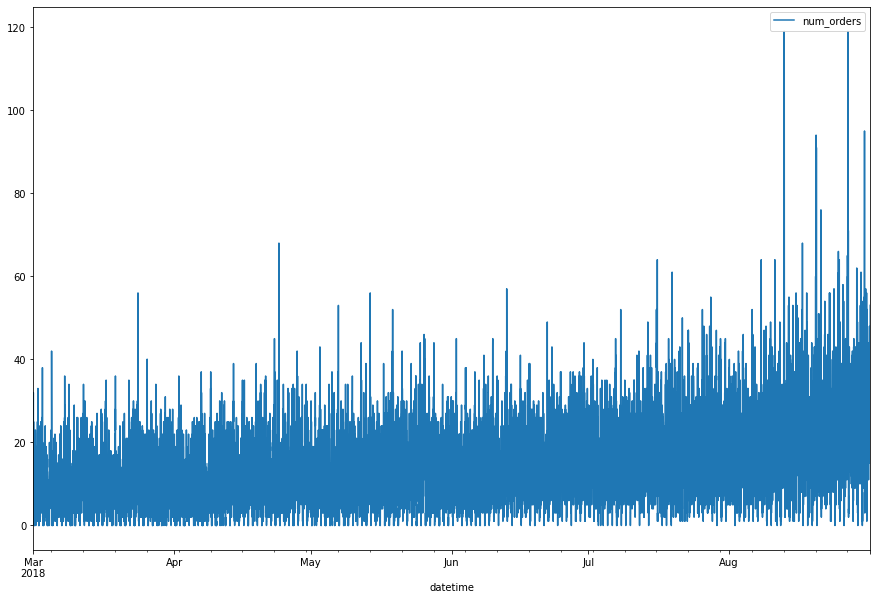

In [ ]:
data.plot(figsize=(15, 10));

Сделаем ресемплинг данных, укажем промежуток в 1 час и найдём сумму этого промежутка

In [ ]:
data = data.resample('1H').sum()
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Вывод: мы выяснили, что у нас есть 26496 строк данных с количеством заказов на такси за пол года с интервалом в 10 минут. Мы сделали ресемплинг данных и изменили интервал на 1 час и указали сумму значений для каждого промежутка

## Анализ

Посмотрим, как примерно распределяются заказы в рамках трёх дней

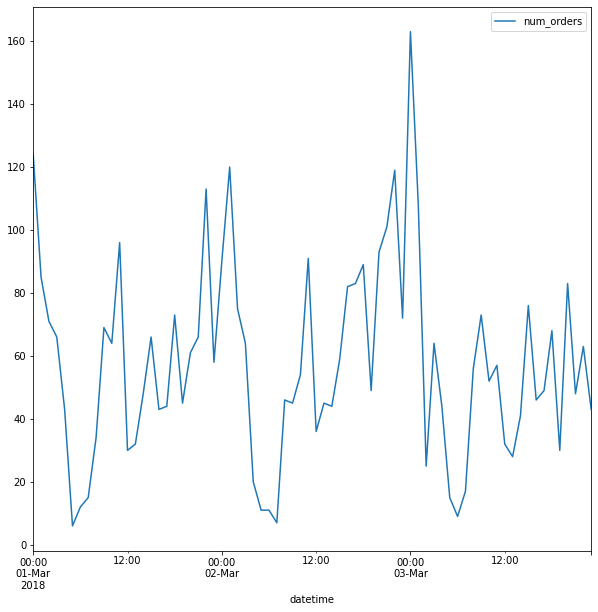

In [ ]:
data['2018-03-01': '2018-03-03'].plot(figsize=(10, 10));

Видим, что есть пики, означающие наибольшее количество заказов в этом временном промежутке, и есть спады ежедневно около 6 утра

Расмотрим тренды и сезонность данных

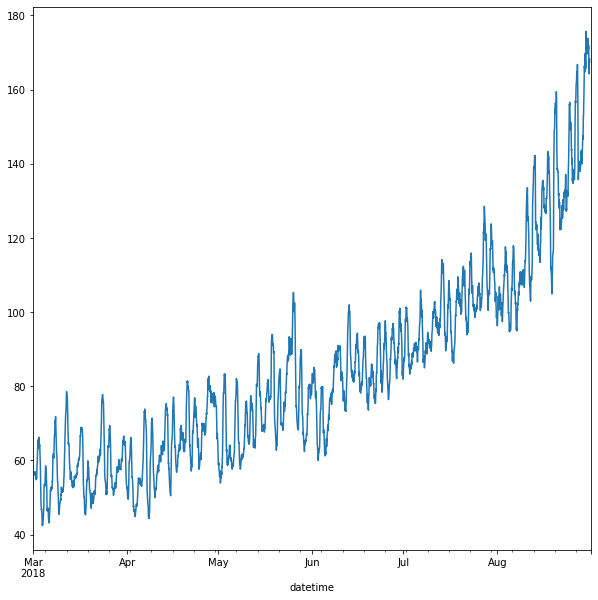

In [ ]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot(ax=plt.gca(), figsize=(10, 10));

График трендов говорит нам о том, что временной ряд - нестационарный, у него есть тренд на возрастание количества заказов

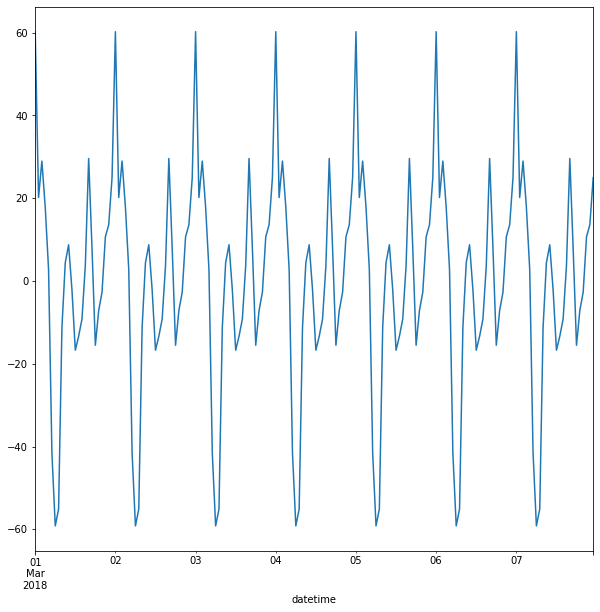

In [ ]:
decomposed.seasonal['2018-03-01': '2018-03-07'].plot(ax=plt.gca(), figsize=(10, 10));

График сезонности говорит нам, что во временном ряде есть цикличность: максимальный рост заказов в вечернее время и максимальный спад рано утром

Вывод: в данных есть свои закономерности, которые помогут нам лучше спрогнозировать заказы. Во-первых, есть тренд на возрастание, во-вторых, есть ежедневная цикличность

## Обучение

### Подготовка признаков

Для начала нам необходимо добавить признаков для обучения модели. Напишем функцию, которая создаст их из имеющихся данных

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Применим функцию к данным

In [ ]:
make_features(data, 24, 24)

In [ ]:
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим выборку на обучающую и тестовую в соотношении 9:1, при этом не перемешивая её, чтобы сохранить временной ряд. Далее удалим пропуски в обучающей выборке

In [ ]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

Разделим выборки на признаки и целевой признак

In [ ]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [ ]:
features_train.head()

,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,0,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,1,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,3,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,9,0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,...,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,108.0,134.041667
2018-08-13 10:00:00,10,0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,...,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,135.250000
2018-08-13 11:00:00,11,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,137.250000


### Обучение моделей

Линейная регрессия

In [ ]:
params = {}
cv_lr = RandomizedSearchCV(LinearRegression(), params, cv=TimeSeriesSplit(6), scoring='neg_root_mean_squared_error')

lr_model = cv_lr.fit(features_train, target_train)
print('RMSE линейной регрессии:', abs(lr_model.best_score_))

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RMSE линейной регрессии: 27.00822254600308


Случайный лес

In [ ]:
params = {'max_depth': range(1, 10),
          'n_estimators': range(10, 51, 10),
          'min_samples_leaf': range(1, 5)}
cv_rf = RandomizedSearchCV(RandomForestRegressor(), params, cv=TimeSeriesSplit(6), scoring='neg_root_mean_squared_error')

rf_model = cv_rf.fit(features_train, target_train)
print('Лучшие параметры случайного леса:', rf_model.best_params_)
print('RMSE случайного леса:', abs(rf_model.best_score_))

Лучшие параметры случайного леса: {'n_estimators': 20, 'min_samples_leaf': 2, 'max_depth': 9}
RMSE случайного леса: 25.667336123632936


CatBoost

In [ ]:
params = {'max_depth': range(1, 5),
          'n_estimators': range(10, 31, 10),
          'learning_rate': np.arange(0.1, 0.5)}
cv_cat = RandomizedSearchCV(CatBoostRegressor(verbose=False), params,
                            cv=TimeSeriesSplit(6), scoring='neg_root_mean_squared_error')

cat_model = cv_cat.fit(features_train, target_train)
print('Лучшие параметры CatBoost:', cat_model.best_params_)
print('RMSE CatBoost:', abs(cat_model.best_score_))

Лучшие параметры CatBoost: {'n_estimators': 20, 'max_depth': 4, 'learning_rate': 0.1}
RMSE CatBoost: 28.436230979279884


Вывод: в данном разделе мы добавили новые признаки в таблицу для того, чтобы модели лучше обучались, затем разделили их на выборки, не смешивая между собой, чтобы сохранить временной ряд. Подобрав гиперпараметры к моделям (линейная, деревья и бустинг), мы попутно оценили RMSE, и получили лучшую модель, которой оказался случайный лес. Проверим её на тестовой выборке

## Тестирование

Для тестирования мы возьмём модель случайного леса с лучшими подобранными параметрами: n_estimators=50, min_samples_leaf=1, max_depth=8 

In [ ]:
rf_model = RandomForestRegressor(n_estimators=30, min_samples_leaf=4, max_depth=9)
rf_model.fit(features_train, target_train)
predict_rf = rf_model.predict(features_test)
print('RMSE на тестовой выборке:', mean_squared_error(target_test, predict_rf, squared=False))

RMSE на тестовой выборке: 44.11184782576674


Вывод: с помощью модели случайного леса мы добились минимальной ошибки в ~44 заказа. Для этого мы провели подготовку данных, исследовали их, подготовили признаки. Затем обучили несколько моделей разного типа, подобрали лучшие гиперпараметры, нашли лучшую и проверили её на тестовой выборке